# Rekko Sandbox

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import logging

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

from time import time

from pyspark.sql import SparkSession

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [10]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.metrics.metrics import Metrics

In [11]:
# Отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [12]:
spark_memory = "2g"
spark_cores = "*"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

In [13]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [14]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Основные данные и пути

In [15]:
path_data = '../data/rekko_sand_rekko'
path_transactions = os.path.join(path_data, 'transactions.csv')
path_checkpoints = '../data/checkpoints'

In [16]:
spark.sparkContext.setCheckpointDir(path_checkpoints)

In [12]:
%%time

transactions = pd.read_csv(
    path_transactions,
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

CPU times: user 3.78 s, sys: 432 ms, total: 4.21 s
Wall time: 4.2 s


In [13]:
transactions.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


In [14]:
transactions.nunique()

element_uid            8296   
user_uid               499663 
consumption_mode       3      
ts                     9634273
watched_time           124958 
device_type            7      
device_manufacturer    100    
dtype: int64

## Подготовка данных

In [15]:
dp = DataPreparator(spark)

In [16]:
df = dp.transform_log(
    path_transactions,
    format_type='csv',
    columns_names={
        'user_id': 'user_uid', 
        'item_id': 'element_uid',
        'relevance': 'watched_time'
    },
    date_format=None,
    header=True
)

In [17]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- relevance: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- context: string (nullable = false)



In [18]:
df.show(3)

+-------+-------+---------+-------------------+----------+
|user_id|item_id|relevance|          timestamp|   context|
+-------+-------+---------+-------------------+----------+
|   5177|   3336|   4282.0|1999-05-01 00:00:00|no_context|
| 593316|    481|   2989.0|1999-05-01 00:00:00|no_context|
| 262355|   4128|    833.0|1999-05-01 00:00:00|no_context|
+-------+-------+---------+-------------------+----------+
only showing top 3 rows



## Рекомендации популярных объектов

In [19]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [20]:
%%time

pr.fit(
    log=df,
    user_features=None,
    item_features=None,
    path=path_checkpoints
)

CPU times: user 10.4 ms, sys: 4.3 ms, total: 14.7 ms
Wall time: 14.5 s


In [21]:
%%time

recs = pr.predict(
    k=10,
    users=None,
    items=None,
    context='no_context',
    log=df,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
)

02-Oct-19 17:05:58, root, DEBUG: Проверка датафреймов
02-Oct-19 17:06:06, root, DEBUG: Выделение дефолтных юзеров
02-Oct-19 17:06:06, root, DEBUG: Выделение дефолтных айтемов
02-Oct-19 17:06:14, root, DEBUG: Среднее количество items у каждого user: 20.0
02-Oct-19 17:06:18, root, DEBUG: Количество items после фильтрации: 30
02-Oct-19 17:06:27, root, DEBUG: Длина recs: 14989890


CPU times: user 44.2 ms, sys: 14 ms, total: 58.2 ms
Wall time: 1min 10s


In [22]:
recs.show(5)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2714| 100140|no_context|0.007084923258417598|
|    747| 100140|no_context|0.006354031292297469|
|   6127| 100140|no_context|0.005409927935379527|
|   3916| 100140|no_context|0.005002897434950823|
|   8771| 100140|no_context|0.004923772779708249|
+-------+-------+----------+--------------------+
only showing top 5 rows



In [23]:
%%time

metric = Metrics.hit_rate_at_k(recs, df, k=10)
metric

CPU times: user 12.3 ms, sys: 5.66 ms, total: 18 ms
Wall time: 1min 20s


0.0002561726603730915

## Сценарий с популярной моделью

In [19]:
df_short = df.limit(1000)
df_short.checkpoint()

DataFrame[user_id: string, item_id: string, relevance: float, timestamp: timestamp, context: string]

In [20]:
popular_scenario = PopularScenario(spark)
popular_params_grid = {'alpha': (0, 1000), 'beta': (0, 1000)}

In [24]:
%%time

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.35,
    k=10, context='no_context',
    to_filter_seen_items=True,
    n_trials=3, n_jobs=1,
    how_to_split='randomly'
)

07-Oct-19 11:39:08, root, DEBUG: Деление на трейн и тест
07-Oct-19 11:39:52, root, DEBUG: Размер трейна:      6268408
07-Oct-19 11:39:57, root, DEBUG: Размер теста_инпут: 6268408
07-Oct-19 11:40:08, root, DEBUG: Размер теста:       3374528
07-Oct-19 11:40:38, root, DEBUG: Начало оптимизации параметров
07-Oct-19 11:40:38, root, DEBUG: Предикт модели в оптимизации
07-Oct-19 11:40:38, root, DEBUG: Проверка датафреймов
07-Oct-19 11:41:47, root, DEBUG: Среднее количество items у каждого user: 8.0
07-Oct-19 11:41:57, root, DEBUG: Количество items после фильтрации: 18
07-Oct-19 11:42:12, root, DEBUG: Длина recs: 8993934
07-Oct-19 11:43:07, root, DEBUG: Подсчет метрики в оптимизации
07-Oct-19 11:45:36, root, DEBUG: Метрика и параметры: (5.403642054744898e-05, {'alpha': 59, 'beta': 65})
[I 2019-10-07 11:45:36,720] Finished trial#0 resulted in value: 5.403642054744898e-05. Current best value is 5.403642054744898e-05 with parameters: {'alpha': 59, 'beta': 65}.
07-Oct-19 11:45:36, root, DEBUG: Пре

CPU times: user 465 ms, sys: 88.8 ms, total: 554 ms
Wall time: 15min 35s


In [54]:
best_params

{'alpha': 59, 'beta': 65}

In [53]:
results = popular_scenario.study.trials_dataframe()

results.head()

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.000054 2019-10-07 11:40:38.885640   
1  1      TrialState.COMPLETE  0.000054 2019-10-07 11:45:36.720899   
2  2      TrialState.COMPLETE  0.000054 2019-10-07 11:50:18.874283   

           datetime_complete params       user_attrs system_attrs  
                              alpha beta some_metric      _number  
0 2019-10-07 11:45:36.719832  59     65   1.0         0            
1 2019-10-07 11:50:18.873271  238    828  1.0         1            
2 2019-10-07 11:54:44.130547  754    448  1.0         2

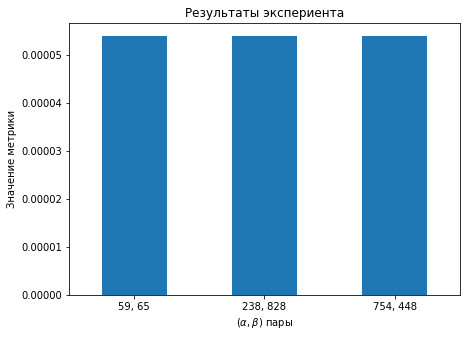

In [52]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты экспериента')

    plt.show()
    

plot_result_value(results)

In [40]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

02-Oct-19 18:19:57, root, DEBUG: Проверка датафреймов
02-Oct-19 18:20:04, root, DEBUG: Выделение дефолтных юзеров
02-Oct-19 18:20:04, root, DEBUG: Выделение дефолтных айтемов
02-Oct-19 18:20:14, root, DEBUG: Среднее количество items у каждого user: 20.0
02-Oct-19 18:20:22, root, DEBUG: Количество items после фильтрации: 30
02-Oct-19 18:20:34, root, DEBUG: Длина recs: 14989890


CPU times: user 39.2 ms, sys: 11.7 ms, total: 50.9 ms
Wall time: 1min 29s


In [41]:
best_recs.show(10)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2714| 100140|no_context|0.007084923258417598|
|    747| 100140|no_context|0.006354031292297469|
|   6127| 100140|no_context|0.005409927935379527|
|   3916| 100140|no_context|0.005002897434950823|
|   8771| 100140|no_context|0.004923772779708249|
|   3336| 100140|no_context| 0.00473358324141876|
|   7079| 100140|no_context|0.004549615825428818|
|   3567| 100140|no_context|0.004384314776337518|
|   1016| 100140|no_context|0.004307678970014763|
|   9467| 100140|no_context|0.003858441739987...|
+-------+-------+----------+--------------------+
only showing top 10 rows

